In [1]:
from utils_others import *

In [2]:
api_key=""
# 放入gemini api (我的api余额已经快用光光了.....捂脸)

In [3]:
# 模型设定
gemini_hypers = {
    'temp': 0.2,  # temp 在0.2 or 0.4是比较好的，不过这个寻优只是通过MAPE,R^2找到，因为gemini没办法得到输出token的log-p，无法调用validation-likelihood function
    # 话又说回来, 似乎validation-likelihood function也不一定使得模型表现更好......
    'alpha': 0.95,
    'beta': 0.3,
    'basic': [False],
    'settings': [SerializerSettings(base=10, prec=3, signed=True,half_bin_correction=True)],
    # prec可能=3
}

model_hypers = {
    'gemini-1.0-pro': {'model': 'gemini-1.0-pro', **gemini_hypers},
    # 'gemini-pro': {'model': 'gemini-pro', **gemini_hypers}
}

model_predict_fns = {
    'gemini-1.0-pro': get_llmtime_predictions_data,  # 此处假定用gpt系列的encoding方式来进行预测
    # 'gemini-pro': get_llmtime_predictions_data
}


In [4]:
datasets = get_datasets()  
datasets_tmp = get_memorization_datasets()
datasets.update(datasets_tmp)

D:\Desktop\Works_left_over\0-已完成 (形式上)\1-Time-LLM\2-llmtime-main\llmtime-main\data1\small_context.py:115: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  series = pd.read_csv(f, index_col=0, parse_dates=True).values.reshape(-1)


In [5]:
# 一些参数设置和数据集选择
dataset_name = 'WineDataset'  # 免费版gemini跑IstanbulTraffic数据集总是会报错(安全不合格), 其他数据集偶尔报错, 目前不知道原因
train, test = datasets[dataset_name]

num_samples = 10  # 跑多少次


In [6]:
def adding_noise(train, loc=0, steps=4, std=5):
    # 噪声固定
    np.random.seed(42)
    noise = np.random.normal(0, std, steps)
    train[loc:(loc+steps)] += noise
    return train

In [7]:
period = 12
std = 0.1*(train.max()-train.min())
num_iteration = int(len(train)/period)

out_counterfactual = {}
MSE =[]
MAE =[]
MAPE = []
R = []

for index in range(num_iteration):
    MSE_tmp =[]
    MAE_tmp =[]
    MAPE_tmp = []
    R_tmp = []
    train_tmp = copy.deepcopy(train)
    loc = index * period
    train_tmp = adding_noise(train_tmp, loc=loc, steps=period, std=std)
    if index > 0:
        time.sleep(60)  # 这里可能需要适当再延长一些
    out_gemini_pro, out_gemini_pro_number = prediction_gemini(model_predict_fns, train, test, model_hypers, num_samples=num_samples, whether_blanket=False, dataset_name=dataset_name, genai_key=api_key)

    mse_amount = 0.0
    mae_amount = 0.0
    mape_amount = 0.0
    rsquare_amount = 0.0
    for i in range(num_samples):
        # seq_pred = out_gemini_pro[dataset_name]['samples'].iloc[i, :]  # 这里关注gemini-pro 
        seq_pred = out_gemini_pro_number[dataset_name]['samples'].iloc[i, :]  # 这里关注gemini-1.0-pro
        
        mse = mean_squared_error(test, seq_pred)
        mae = mean_absolute_error(test, seq_pred)
        mape = metrics.mean_absolute_percentage_error(test, seq_pred)*100
        r2 = r2_score(test, seq_pred)
    
        MSE_tmp.append(mse)
        MAE_tmp.append(mae)
        MAPE_tmp.append(mape)
        R_tmp.append(r2)
    
    MSE.append(MSE_tmp)
    MAE.append(MAE_tmp)
    MAPE.append(MAPE_tmp)
    R.append(R_tmp)


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gemini-1.0-pro', 'temp': 0.2, 'alpha': 0.95, 'beta': 0.3, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=' ,', bit_sep=' ', plus_sign='', minus_sign=' -', half_bin_correction=True, decimal_point='', missing_str=' Nan'), 'dataset_name': 'WineDataset'}) 
 with NLL inf


  0%|          | 0/1 [00:00<?, ?it/s]

Index: 0
Index: 1
Index: 2
Index: 3


KeyboardInterrupt: 

AxisError: axis 1 is out of bounds for array of dimension 1

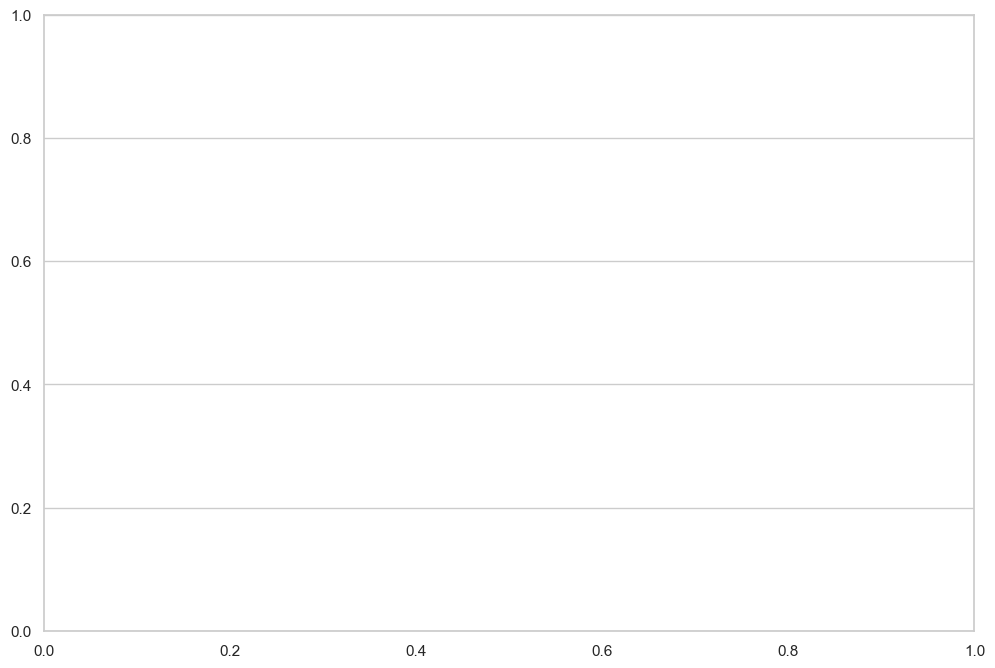

In [8]:
fig_counterfactual(R, metric_name='R^2', dataset_name='WineDataset')